# Model selection and community detection

A key question for the generation of sparse state networks is _how_ sparse. If we lump all state nodes with each physical node, we lose all higher-order information and may underfit. On the other hand, keeping all state nodes may overfit.

In this tutorial we will generate third-order state networks from path data and from there generate multiple sparse networks with different number of (lumped) state nodes and evaluate the result with Infomap.

## Measure performance with Infomap

We will use Infomap to choose how many state nodes we will include in our model.

The `partition` function takes a state network as input and returns the codelength of the best partition after 10 trials. It can optionally write the resulting partition to `cluster_filename`.

The `codelength` function takes a state network and a partition and calculates the codelength.

In [1]:
import infomap
from math import inf

def partition(input_filename, cluster_filename=None):
    im = infomap.Infomap("-2 -d")
    im.network().readInputData(input_filename)

    L_min = inf
    for _ in range(10):
        im.run()
        L = im.codelength()
        if L < L_min:
            L_min = L    
            if cluster_filename:
                im.writeClu(cluster_filename, True)

    return L_min

def codelength(input_filename, cluster_filename):
    im = infomap.Infomap(f"--no-infomap --input {input_filename} -d -2 --cluster-data {cluster_filename}")
    im.run()
    return im.codelength()

## Generate (noisy) data

For this example, we start by generating data from a model that requires third order states for Infomap to successfully find the planted partition.

To make the problem more interesting, we can introduce "leakage" between the partitions. That is, a path may leak between the left and right hand side with some probability $\mu$.

<img src="../figures/model.png" width="400">                                                     
<img src="../figures/model_leak.png" width="400">

Figure 1: On top, the model with $\mu = 0$. On bottom $\mu = 0.5$.

We will start by investigating how the leaking affects the performance of Infomap.

**TODO**:

- Create the planted partitions and for comparing codelength when all nodes belong to one or two modules
- Generate 10 state sets of path data with $\mu$ ranging from $0$ to $0.5$
- Partition the 10 networks with infomap and calculate the codelength for the one-module and two-module solutions

In [2]:
import numpy as np
import simulation

mus = np.linspace(0, 0.5, 10) # leak probability
L = [] # codelength
L1 = [] # one module codelength
L2 = [] # two module codelength
filenames = []
output_dir = "../output"

num_nodes = 2 # number of nodes per side
network = simulation.example_network(num_nodes)
simulation.write_partitions(f"{output_dir}/_one_module.clu", network, partitions=1)
simulation.write_partitions(f"{output_dir}/_two_modules.clu", network, partitions=2)

for i, mu in enumerate(mus):
    network = simulation.example_network(num_nodes)
    paths = simulation.run(network, n=10000, steps=3, mu=mu)
    
    paths_filename = f"{output_dir}/toy_paths_{i}.net"
    print(f"Writing {paths_filename}...")
    simulation.write_paths(paths_filename, network, paths)
    filenames.append(paths_filename)

    net_filename = f"{output_dir}/toy_states2.net"
    simulation.write_net(net_filename, network)

    l = partition(net_filename)
    l1 = codelength(net_filename, f"{output_dir}/_one_module.clu")
    l2 = codelength(net_filename, f"{output_dir}/_two_modules.clu")
    L.append(l)
    L1.append(l1)
    L2.append(l2)

Writing ../output/toy_paths_0.net...
Writing ../output/toy_paths_1.net...
Writing ../output/toy_paths_2.net...
Writing ../output/toy_paths_3.net...
Writing ../output/toy_paths_4.net...
Writing ../output/toy_paths_5.net...
Writing ../output/toy_paths_6.net...
Writing ../output/toy_paths_7.net...
Writing ../output/toy_paths_8.net...
Writing ../output/toy_paths_9.net...


### Analyze leak parameter

**TODO**:

- Plot the leak parameter $\mu$ vs codelength $L$

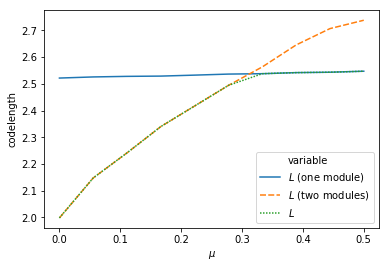

In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns

df = pd.DataFrame({ "$\mu$": mus, "$L$ (one module)": L1, "$L$ (two modules)": L2, "$L$": L })
data = pd.melt(df, id_vars=["$\mu$"], value_name="codelength")
sns.lineplot(x="$\mu$", y="codelength", data=data, hue="variable", style="variable")

## Find the best sparse representation

Infomap cannot detect the planted partitions when the leakage is too high.

For this example, this happens around $\mu = 0.3$, so we will choose $\mu \approx 0.16666$.

We will use ten-fold cross validation to find how many state nodes we will have in our sparse model.

**TODO**:

- Create 10 training-validation splits with different random seeds
- Run divisive clustering on each training network
- Cluster the validation network according to the training network
- Run Infomap on the training network to calculate the codelength
- Calculate the codelength of the validation network given the training partition

In [4]:
from state_network import StateNetwork

mu_idx = 3
mu = mus[mu_idx]
print(mu)

num_states = []
L_lumped = []
L_validation = []
filename = filenames[mu_idx]
thresholds = np.geomspace(1, 1e-5, 10)

for seed in range(10):
    network, validation = StateNetwork.from_paths(filename,
                                                  create_validation=True,
                                                  markov_order=3,
                                                  seed=seed)

    network.aggregate(2)
    network.cluster_state_nodes(order=2, js_div_threshold=thresholds[-1])

    network.aggregate(3)
    for i, threshold in enumerate(thresholds):
        network.cluster_state_nodes(order=3, js_div_threshold=threshold)
        validation.cluster_from_network(network)

        network.write_clustered_network(f"{output_dir}/clustered.net")
        validation.write_clustered_network(f"{output_dir}/validation.net")

        num_states.append(network.num_clustered_state_nodes)
        L_lumped.append(partition(f"{output_dir}/clustered.net", f"{output_dir}/clustered.clu"))
        L_validation.append(codelength(f"{output_dir}/validation.net", f"{output_dir}/clustered.clu"))

0.16666666666666666
Read path data from file '../output/toy_paths_3.net'...
Done, parsed 180/180 paths
 -> 24 return paths
 -> 84 states in training network
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing c

Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Writing clustered state network to file '../output/clustered.net'...
Writing clustered state network to file '../output/validation.net'...
Read path data from file '.

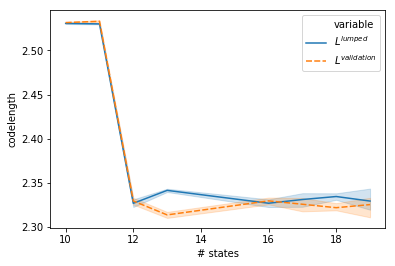

In [5]:
df3 = pd.DataFrame({ "# states": num_states, "$L^{lumped}$": L_lumped, "$L^{validation}$": L_validation })
data2 = pd.melt(df3, id_vars=["# states"], value_name="codelength")
sns.lineplot(x="# states", y="codelength", data=data2, hue="variable", style="variable")

## Resulting sparse network

<img src="../figures/toy_states2_order3.png" width="500">

Figure 2: Resulting sparse network